In [63]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies.head()


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [3]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]
with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
    

In [4]:
eddy = 382

dic = dic_sample[f'Eddy{eddy}']
t0, t_r = 30, 5
days = list(dic.keys())[t0 - t_r : t0 + t_r + 1]

df_int = pd.concat([dic[day].assign(Day=int(day[3:])) for day in days], ignore_index=True)
df_int = df_int[df_int['Depth'] >= -1000]
df_int.head()


,x,y,Q,w,z,Depth,TD,Grad,Day
0,491.571462,492.083395,"[[-0.003969096910500763, 0.001562166203494834]...",-0.029639,0,-1.783320,0.000000,NaN,2698
1,490.174309,491.388898,"[[-0.003993579956302959, 0.0015182870080628302...",-0.029725,1,-5.879627,1.560244,0.497080,2698
2,489.622731,491.054422,"[[-0.003998716718951495, 0.001495514756028457]...",-0.029761,2,-10.725783,2.203710,0.606399,2698
3,489.307382,490.813176,"[[-0.0040024933744435415, 0.001473300402119757...",-0.029789,3,-16.383097,2.596057,0.765014,2698
4,489.127695,490.622722,"[[-0.004006593441129104, 0.0014491480279933452...",-0.029805,4,-22.925581,2.847027,1.059916,2698


### Clustering Technique

#### Solve the Problem

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

In [5]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))
    

In [6]:
def cost(p, x_t, y_t, x_ref, y_ref):
    dx, dy, θ = p
    c, s = np.cos(θ), np.sin(θ)
    tx =  x_t * c - y_t * s + dx
    ty =  x_t * s + y_t * c + dy
    return np.sum((tx - x_ref)**2 + (ty - y_ref)**2)

def rmse(p, x_t, y_t, x_ref, y_ref):
    return np.sqrt(cost(p, x_t, y_t, x_ref, y_ref) / len(x_ref))

def resample_coords(x, y, n):
    # cumulative distance along the curve
    d = np.hypot(np.diff(x), np.diff(y))
    s = np.concatenate([[0], np.cumsum(d)])
    fx = interp1d(s, x, kind='linear')
    fy = interp1d(s, y, kind='linear')
    s_new = np.linspace(0, s[-1], n)
    x2, y2 = fx(s_new), fy(s_new)
    return x2 - x2[0], y2 - y2[0]

days = df_int['Day'].unique()
mid_day = days[len(days)//2]
ref = df_int[df_int['Day'] == mid_day]
n_ref = len(ref)
x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)

results = []
for day in days:
    df_day = df_int[df_int['Day'] == day]
    x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)

    res = minimize(
        lambda p: cost(p, x_t, y_t, x_ref, y_ref),
        [0, 0, 0],
        bounds=[(None, None), (None, None), (0, 2*np.pi)]
    )
    if res.success:
        dx, dy, θ = res.x
        results.append({
            'Day':    day,
            'x_delta': dx,
            'y_delta': dy,
            'theta':   np.rad2deg(θ),
            'rmse':    rmse(res.x, x_t, y_t, x_ref, y_ref)
        })

df_best_shift = pd.DataFrame(results)
df_best_shift


,Day,x_delta,y_delta,theta,rmse
0,2698,-2.008689,2.408212,16.736123,2.645212
1,2699,-2.026173,1.401723,8.259736,2.407780
2,2700,-2.041580,2.271557,0.000000,2.301909
3,2701,-3.550352,1.955479,0.000000,2.784791
4,2702,-4.569365,-1.208302,0.000000,2.530834
5,2703,0.000000,0.000000,0.000000,0.000000
6,2704,-3.063211,-1.579007,13.033024,1.330256
7,2705,-0.841566,-1.865074,18.545076,1.494201
8,2706,1.752151,0.385009,12.149625,1.046073
9,2707,1.190608,2.329407,0.000000,1.950386


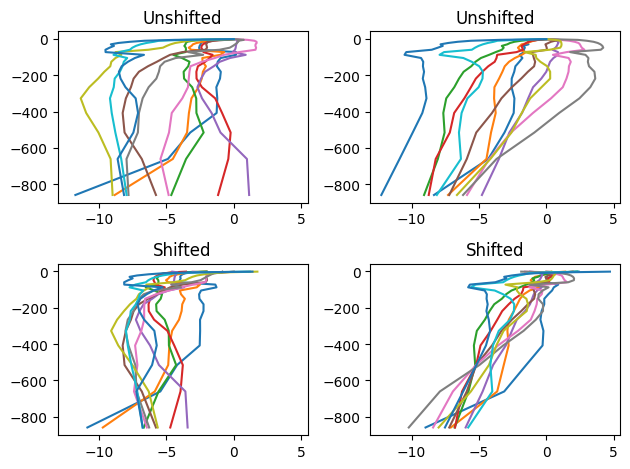

In [7]:
fig, axs = plt.subplots(2, 2)
df_shifted = df_int.copy()
for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    i_surf = df['Depth'].abs().argmin()
    x, y = df['x']-df.iloc[i_surf]['x'], df['y']-df.iloc[i_surf]['y']
    x, y = x.values, y.values
    axs[0,0].plot(x, df['Depth'])
    axs[0,1].plot(y, df['Depth'])
    axs[0,0].set_title('Unshifted')
    axs[0,1].set_title('Unshifted')
    data = df_best_shift[df_best_shift['Day']==day]
    x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
    theta = data.iloc[0]['theta']

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + x_delta
    y_shifted = points_rotated[:, 1] + y_delta

    df_shifted.loc[df_shifted['Day']==day, 'x'] = x_shifted
    df_shifted.loc[df_shifted['Day']==day, 'y'] = y_shifted

    axs[1,0].plot(x_shifted, df['Depth'])
    axs[1,1].plot(y_shifted, df['Depth'])
    axs[1,0].set_title('Shifted')
    axs[1,1].set_title('Shifted')

xmin, xmax = 0, 0 
for ax in axs.flat:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
plt.tight_layout()
plt.show()


,Depth,x,y,w,z,TD
0,-1.783320,0.000000,0.000000,-0.025148,0.0,0.000000
1,-5.879627,-1.460434,-0.379482,-0.026574,1.0,1.508931
2,-10.725783,-2.219305,-0.757149,-0.027138,2.0,2.344907
3,-16.383097,-2.554142,-0.923349,-0.027402,3.0,2.715919
4,-22.925581,-2.848616,-1.096295,-0.027324,4.0,3.052290


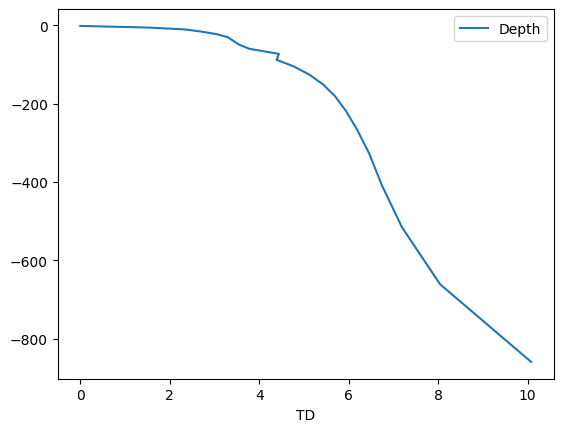

In [8]:
df_mean = df_shifted.groupby('Depth').mean().drop(columns=['Q', 'TD', 'Grad', 'Day'])
df_mean = df_mean.sort_index(ascending=False)
df_mean = df_mean.reset_index()
i_surf = df_mean['Depth'].abs().argmin()
df_mean['x'] = df_mean['x'] - df_mean.iloc[i_surf]['x']
df_mean['y'] = df_mean['y'] - df_mean.iloc[i_surf]['y']

df_mean['TD'] = np.hypot(df_mean['x'], df_mean['y'])
df_mean.plot(x='TD', y='Depth')
df_mean.head()


### Generalise

In [283]:
dic_mean = {}

t_r = 7
for eddy in sample_eddies:
    dic = dic_sample[f'Eddy{eddy}']
    
    df_mean = []
    
    for t0 in range(t_r, len(dic) - t_r):
        
        days = list(dic.keys())[t0 - t_r : t0 + t_r + 1]
        
        # Create time interval dataset
        df_int = pd.concat([dic[day].assign(Day=int(day[3:])) for day in days], ignore_index=True)
        df_int = df_int[df_int['Depth'] >= -1000] # Disregard deep centers for simplicity
        
        # Pick your reference snapshot
        days = df_int['Day'].unique()
        mid_day = days[len(days)//2]
        ref = df_int[df_int['Day'] == mid_day]
        n_ref = len(ref)
        x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)
        
        # Find Optimal Shift
        results = []
        for day in days:
            df_day = df_int[df_int['Day'] == day]
            x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)
        
            res = minimize(
                lambda p: cost(p, x_t, y_t, x_ref, y_ref),
                [0, 0, 0],
                bounds=[(None, None), (None, None), (0, 2*np.pi)]
            )
            if res.success:
                dx, dy, θ = res.x
                results.append({
                    'Day':    day,
                    'x_delta': dx,
                    'y_delta': dy,
                    'theta':   np.rad2deg(θ),
                    'rmse':    rmse(res.x, x_t, y_t, x_ref, y_ref)
                })
        df_best_shift = pd.DataFrame(results)
        
        # Apply optimal shift to dataset
        df_shifted = df_int.copy()
        for day in df_int['Day'].unique():
            df = df_int[df_int['Day']==day]
            i_surf = df['Depth'].abs().argmin()
            x, y = df['x']-df.iloc[i_surf]['x'], df['y']-df.iloc[i_surf]['y']
            x, y = x.values, y.values
            data = df_best_shift[df_best_shift['Day']==day]
            if len(data) > 0:
                x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
                theta = data.iloc[0]['theta']
            
                points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
                x_shifted = points_rotated[:, 0] + x_delta
                y_shifted = points_rotated[:, 1] + y_delta
            
                df_shifted.loc[df_shifted['Day']==day, 'x'] = x_shifted
                df_shifted.loc[df_shifted['Day']==day, 'y'] = y_shifted
            else:
                df_shifted.loc[df_shifted['Day']==day, 'x'] = np.nan
                df_shifted.loc[df_shifted['Day']==day, 'y'] = np.nan
        
        # Find mean of shifted interval data
        df_mean_int = df_shifted.groupby('Depth').mean().drop(columns=['Q', 'TD', 'Grad', 'Day'])
        df_mean_int = df_mean_int.sort_index(ascending=False)
        df_mean_int = df_mean_int.reset_index()
        i_surf = df_mean_int['Depth'].abs().argmin()
        df_mean_int['x'] = df_mean_int['x'] - df_mean_int.iloc[i_surf]['x']
        df_mean_int['y'] = df_mean_int['y'] - df_mean_int.iloc[i_surf]['y']
        df_mean_int = df_mean_int.reset_index()
        df_mean_int['TD'] = np.hypot(df_mean_int['x'], df_mean_int['y'])
        df_mean_int['Day'] = mid_day
    
        df_mean.append(df_mean_int)
    df_mean = pd.concat(df_mean, ignore_index=True)

    dic_mean[f'Eddy{eddy}'] = df_mean.drop(columns=['index'])


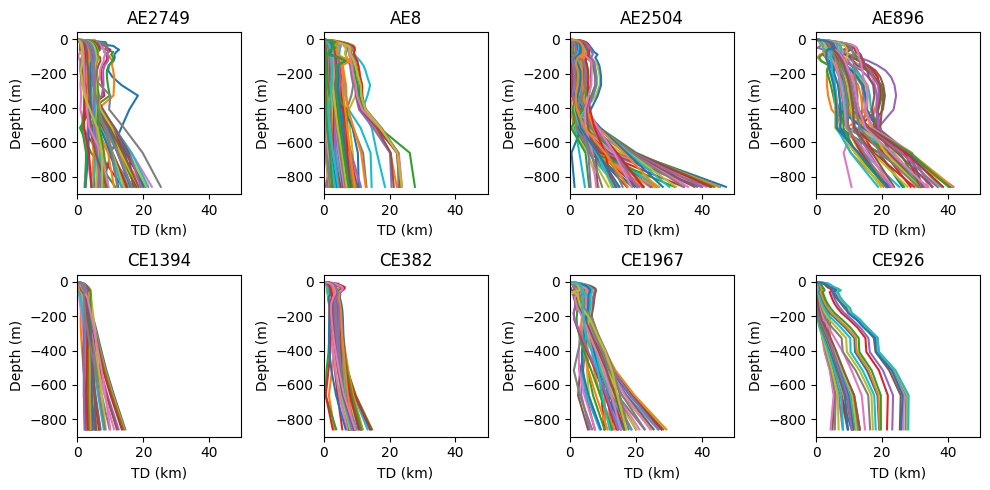

In [285]:
fig, axs = plt.subplots(2, 4, figsize=(10,5))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df_mean = dic_mean[f'Eddy{eddy}']
    for day in df_mean['Day'].unique():
        df = df_mean[df_mean['Day']==day]
        ax.plot(df['TD'], df['Depth'])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    ax.set_title(f'{cyc}{eddy}')
xmax =  0 
for ax in axs.flat:
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(0, xmax)
    ax.set_xlabel('TD (km)')
    ax.set_ylabel('Depth (m)')
plt.tight_layout()
plt.show()


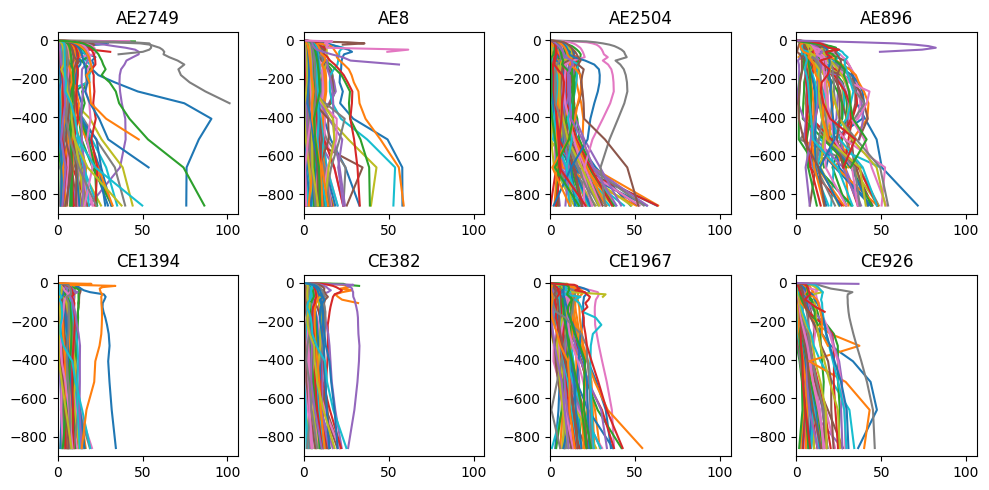

In [256]:
# original 
fig, axs = plt.subplots(2, 4, figsize=(10,5))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[f'Eddy{eddy}']
    for day in dic.keys():
        df = dic[day]
        df = df[df['Depth'] >= -1000]
        TD = np.hypot(df['x']-df.iloc[0]['x'], df['y']-df.iloc[0]['y'])
        ax.plot(TD, df['Depth'])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    ax.set_title(f'{cyc}{eddy}')
xmax =  0 
for ax in axs.flat:
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(0, xmax)
plt.tight_layout()
plt.show()


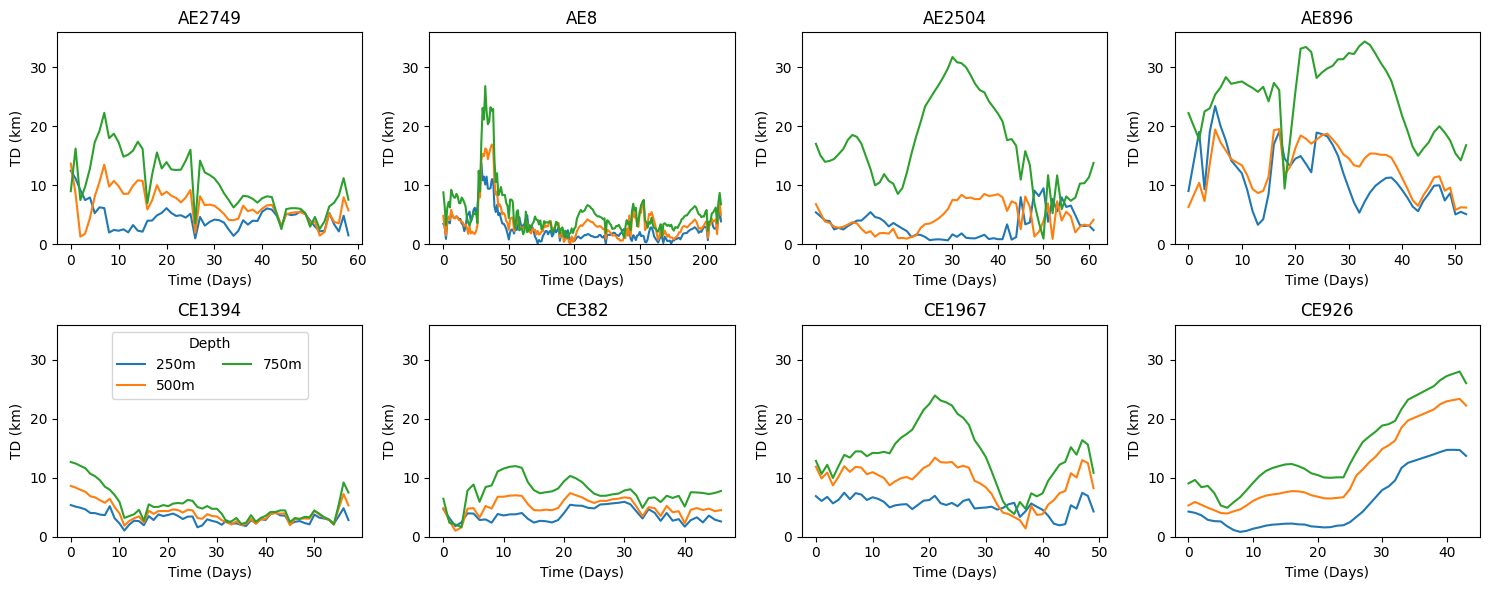

In [286]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = dic_mean[f'Eddy{eddy}']
    df_mean_interp = []
    
    for day, group in df.groupby('Day'):
        TD, depth = group['TD'].values, -group['Depth'].values
        depth_grid = np.round(np.arange(depth.min(), depth.max() + 1, 10) / 10) * 10
        TD_interp = np.interp(depth_grid, depth, TD)
        df_mean_interp.append(pd.DataFrame({'TD': TD_interp, 'Depth': depth_grid, 'Day': day}))
    
    df_mean_interp = pd.concat(df_mean_interp, ignore_index=True)
    
    interval = 250
    for d in range(interval, round(df_mean_interp['Depth'].max())+interval, interval):
        df = df_mean_interp[df_mean_interp['Depth']==d]
        if len(df) > 0:
            ax.plot(df['Day']-df_mean_interp['Day'].min(), df['TD'], label=f'{d}m')
    if eddy == 1394:
        ax.legend(loc='upper center', ncol=2, title='Depth')
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('TD (km)')
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    ax.set_title(f'{cyc}{eddy}')

ymax =  0 
for ax in axs.flat:
    ymax = max(ymax, ax.get_ylim()[1])
for ax in axs.flat:
    ax.set_ylim(0, ymax)

plt.tight_layout()
plt.show()

#### Single Case

In [279]:
def case_data(eddy, t0):
    dic = dic_sample[f'Eddy{eddy}']
    t_r = 7
    days = list(dic.keys())[t0 - t_r : t0 + t_r + 1]
    
    # Time interval dataset
    df_int = pd.concat([dic[day].assign(Day=int(day[3:])) for day in days], ignore_index=True)
    df_int = df_int[df_int['Depth'] >= -1000] # Disregard deep centers for simplicity
    
    # Reference snapshot
    days = df_int['Day'].unique()
    mid_day = days[len(days)//2]
    ref = df_int[df_int['Day'] == mid_day]
    n_ref = len(ref)
    x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)
    
    # Optimal Shift
    results = []
    for day in days:
        df_day = df_int[df_int['Day'] == day]
        x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)
    
        res = minimize(
            lambda p: cost(p, x_t, y_t, x_ref, y_ref),
            [0, 0, 0],
            bounds=[(None, None), (None, None), (0, 2*np.pi)]
        )
        if res.success:
            dx, dy, θ = res.x
            results.append({
                'Day':    day,
                'x_delta': dx,
                'y_delta': dy,
                'theta':   np.rad2deg(θ),
                'rmse':    rmse(res.x, x_t, y_t, x_ref, y_ref)
            })
    df_best_shift = pd.DataFrame(results)
    
    # Apply optimal shift to dataset
    df_shifted = df_int.copy()
    for day in df_int['Day'].unique():
        df = df_int[df_int['Day']==day]
        i_surf = df['Depth'].abs().argmin()
        x, y = df['x']-df.iloc[i_surf]['x'], df['y']-df.iloc[i_surf]['y']
        x, y = x.values, y.values
        data = df_best_shift[df_best_shift['Day']==day]
        if len(data) > 0:
            x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
            theta = data.iloc[0]['theta']
        
            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + x_delta
            y_shifted = points_rotated[:, 1] + y_delta
        
            df_shifted.loc[df_shifted['Day']==day, 'x'] = x_shifted
            df_shifted.loc[df_shifted['Day']==day, 'y'] = y_shifted
        else:
            df_shifted.loc[df_shifted['Day']==day, 'x'] = np.nan
            df_shifted.loc[df_shifted['Day']==day, 'y'] = np.nan
    
    # Find mean of shifted interval data
    df_mean_int = df_shifted.groupby('Depth').mean().drop(columns=['Q', 'TD', 'Grad', 'Day'])
    df_mean_int = df_mean_int.sort_index(ascending=False)
    df_mean_int = df_mean_int.reset_index()
    i_surf = df_mean_int['Depth'].abs().argmin()
    df_mean_int['x_orig'] = df_mean_int['x']
    df_mean_int['y_orig'] = df_mean_int['y']
    df_mean_int['x'] = df_mean_int['x'] - df_mean_int.iloc[i_surf]['x']
    df_mean_int['y'] = df_mean_int['y'] - df_mean_int.iloc[i_surf]['y']
    df_mean_int = df_mean_int.reset_index().drop(columns=['index'])
    df_mean_int['TD'] = np.hypot(df_mean_int['x'], df_mean_int['y'])
    df_mean_int['Day'] = mid_day
    
    return df_int, df_shifted, df_mean_int


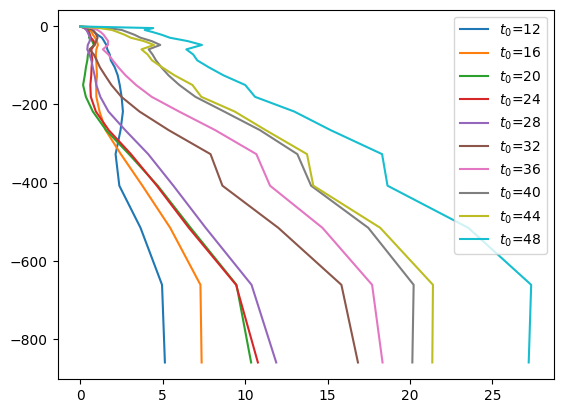

In [266]:
eddy = 926

for t0 in range(t_r+5, 50, 4):
    df_int, df_shifted, df_mean_int = case_data(eddy, t0)
    
    plt.plot(df_mean_int['TD'], df_mean_int['Depth'], label=fr'$t_0$={t0}')
plt.legend()


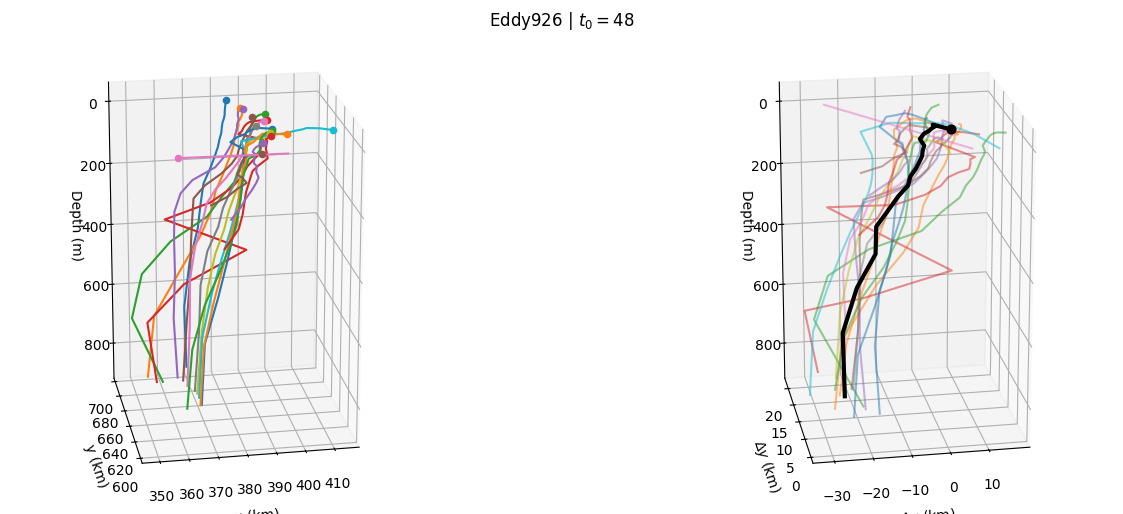

In [268]:
eddy = 926

t0 = 48
df_int, df_shifted, df_mean_int = case_data(eddy, t0)
elev = 20
azim = 260

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for day in df_shifted['Day'].unique():    
    df1 = df_int[df_int['Day'] == day]
    ax1.plot(df1['x'], df1['y'], -df1['Depth'], alpha=1)
    ax1.scatter(df1.iloc[0]['x'], df1.iloc[0]['y'], -df1.iloc[0]['Depth'], alpha=1)

    df2 = df_shifted[df_shifted['Day'] == day]
    ax2.plot(df2['x'], df2['y'], -df2['Depth'], alpha=0.5)

ax2.plot(df_mean_int['x_orig'], df_mean_int['y_orig'], -df_mean_int['Depth'], 'k', linewidth=3)
ax2.scatter(df_mean_int.iloc[0]['x_orig'], df_mean_int.iloc[0]['y_orig'], -df_mean_int.iloc[0]['Depth'], color='k', s=40)

ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('Depth (m)')
ax2.set_xlabel(r'$\Delta x$ (km)')
ax2.set_ylabel(r'$\Delta y$ (km)')
ax2.set_zlabel('Depth (m)')
ax1.set_box_aspect([1, 1, 1.5])
ax2.set_box_aspect([1, 1, 1.5])
ax1.invert_zaxis()
ax2.invert_zaxis()
ax1.view_init(elev=elev, azim=azim)
ax2.view_init(elev=elev, azim=azim)
plt.suptitle(fr'Eddy{eddy} | $t_0=${t0}')
plt.tight_layout()
plt.show()

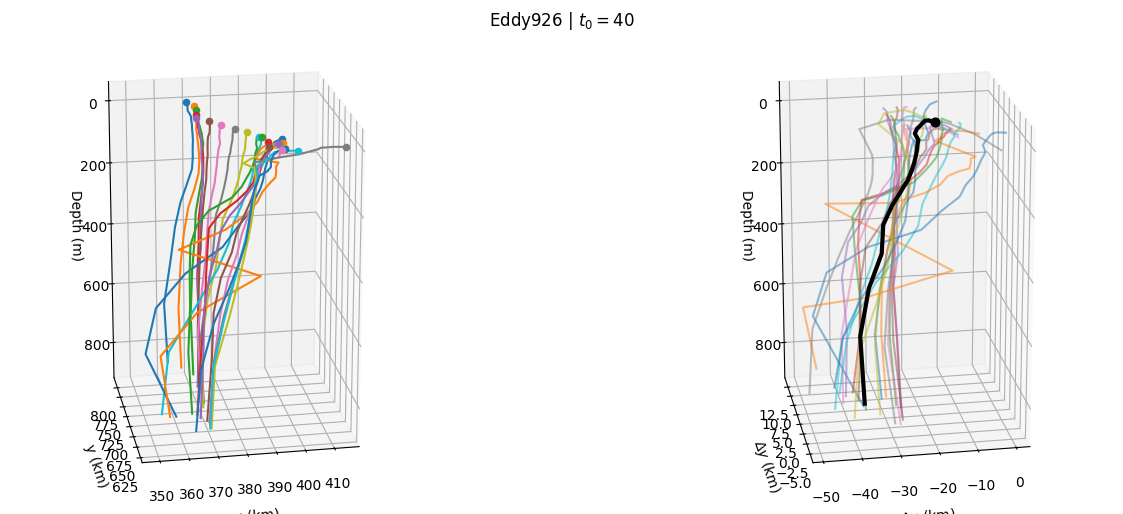

In [269]:
eddy = 926

t0 = 40
df_int, df_shifted, df_mean_int = case_data(eddy, t0)
elev = 20
azim = 260

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for day in df_shifted['Day'].unique():    
    df1 = df_int[df_int['Day'] == day]
    ax1.plot(df1['x'], df1['y'], -df1['Depth'], alpha=1)
    ax1.scatter(df1.iloc[0]['x'], df1.iloc[0]['y'], -df1.iloc[0]['Depth'], alpha=1)

    df2 = df_shifted[df_shifted['Day'] == day]
    ax2.plot(df2['x'], df2['y'], -df2['Depth'], alpha=0.5)

ax2.plot(df_mean_int['x_orig'], df_mean_int['y_orig'], -df_mean_int['Depth'], 'k', linewidth=3)
ax2.scatter(df_mean_int.iloc[0]['x_orig'], df_mean_int.iloc[0]['y_orig'], -df_mean_int.iloc[0]['Depth'], color='k', s=40)

ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('Depth (m)')
ax2.set_xlabel(r'$\Delta x$ (km)')
ax2.set_ylabel(r'$\Delta y$ (km)')
ax2.set_zlabel('Depth (m)')
ax1.set_box_aspect([1, 1, 1.5])
ax2.set_box_aspect([1, 1, 1.5])
ax1.invert_zaxis()
ax2.invert_zaxis()
ax1.view_init(elev=elev, azim=azim)
ax2.view_init(elev=elev, azim=azim)
plt.suptitle(fr'Eddy{eddy} | $t_0=${t0}')
plt.tight_layout()
plt.show()




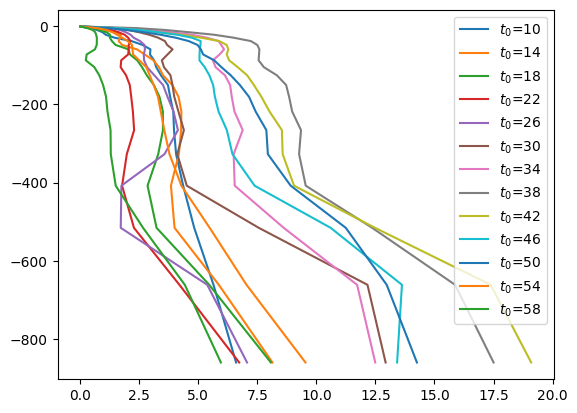

In [278]:
eddy = 8

for t0 in range(10, 60, 4):
    df_int, df_shifted, df_mean_int = case_data(eddy, t0)
    
    plt.plot(df_mean_int['TD'], df_mean_int['Depth'], label=fr'$t_0$={t0}')
plt.legend()


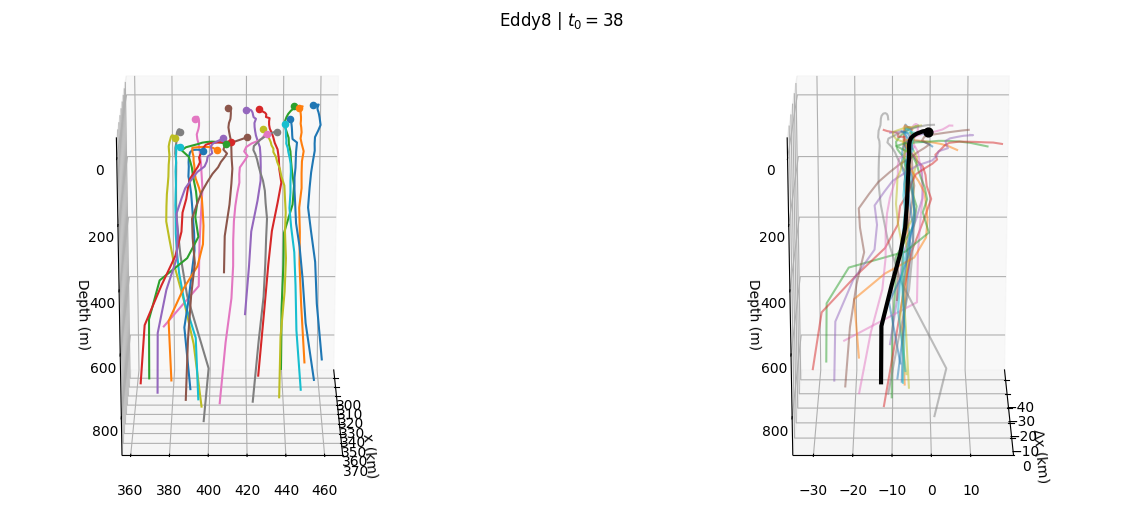

In [277]:
eddy = 8

t0 = 38
df_int, df_shifted, df_mean_int = case_data(eddy, t0)
elev = 20
azim = 0

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for day in df_shifted['Day'].unique():    
    df1 = df_int[df_int['Day'] == day]
    ax1.plot(df1['x'], df1['y'], -df1['Depth'], alpha=1)
    ax1.scatter(df1.iloc[0]['x'], df1.iloc[0]['y'], -df1.iloc[0]['Depth'], alpha=1)

    df2 = df_shifted[df_shifted['Day'] == day]
    ax2.plot(df2['x'], df2['y'], -df2['Depth'], alpha=0.5)

ax2.plot(df_mean_int['x_orig'], df_mean_int['y_orig'], -df_mean_int['Depth'], 'k', linewidth=3)
ax2.scatter(df_mean_int.iloc[0]['x_orig'], df_mean_int.iloc[0]['y_orig'], -df_mean_int.iloc[0]['Depth'], color='k', s=40)

ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_zlabel('Depth (m)')
ax2.set_xlabel(r'$\Delta x$ (km)')
ax2.set_ylabel(r'$\Delta y$ (km)')
ax2.set_zlabel('Depth (m)')
ax1.set_box_aspect([1, 1, 1.5])
ax2.set_box_aspect([1, 1, 1.5])
ax1.invert_zaxis()
ax2.invert_zaxis()
ax1.view_init(elev=elev, azim=azim)
ax2.view_init(elev=elev, azim=azim)
plt.suptitle(fr'Eddy{eddy} | $t_0=${t0}')
plt.tight_layout()
plt.show()